In [14]:
#izracunati rdkit 2d deskriptore, istrenirati XGBoost regression model

In [56]:
import pandas as pd 
import numpy as np 
from rdkit import Chem 
from rdkit.Chem import AllChem, Draw, Descriptors
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
# Učitavanje CSV datoteke
data = pd.read_csv('C:/Users/ivana/REPOZITORIJ/DATA/solubility_new.csv')

In [17]:
# Pretvaranje SMILES zapisa u molekulu
mol_column=data.smiles.apply(Chem. MolFromSmiles).rename('mol', inplace=True)

In [18]:
# Pretvaranje molekula u numeričke značajke
logp=mol_column.apply(Descriptors.MolLogP).rename('logp', inplace=True) 
molwt=mol_column.apply(Descriptors.MolWt).rename('molwt', inplace=True) 
balabanj=mol_column.apply(Descriptors.BalabanJ).rename('balabanj', inplace=True) 
tpsa=mol_column.apply(Descriptors.TPSA).rename('tpsa', inplace=True)

In [19]:
final_data=pd.concat([data, mol_column, logp, molwt, balabanj, tpsa], axis=1) 
final_data.head(5) 

,smiles,Solubility,mol,logp,molwt,balabanj,tpsa
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,<rdkit.Chem.rdchem.Mol object at 0x000001EAE8C...,6.9541,312.606,2.998602,0.00
1,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x000001EAE8C...,2.4854,422.525,1.084427,56.60
2,CCC1CCC(CCC(=O)O)C1,-3.286116,<rdkit.Chem.rdchem.Mol object at 0x000001EAE8C...,2.6775,170.252,2.145839,37.30
3,CC12C=CC(=O)C=C1CCC1C2C(O)CC2(C)C1CC(O)C2(O)C(...,-2.664549,<rdkit.Chem.rdchem.Mol object at 0x000001EAE8C...,0.5284,376.449,1.776978,115.06
4,O=C(OCCCOCCCOC(=O)c1ccccc1)c1ccccc1,-4.595503,<rdkit.Chem.rdchem.Mol object at 0x000001EAE8C...,3.4972,342.391,1.447050,61.83


In [20]:
final_data.to_csv('C:/Users/ivana/REPOZITORIJ/DATA/solubility_all_new_data.csv')

In [86]:
train_set,test_set=train_test_split(final_data,test_size=.2,random_state=42) 
train_set.shape, test_set.shape

((2680, 7), (671, 7))

In [87]:
# Odabir značajki i ciljne varijable
features = ['molwt', 'logp', 'balabanj', 'tpsa']
target = 'Solubility'

# Podijela podataka na skupove za treniranje, validaciju i testiranje
X_train, X_test, y_train, y_test = train_test_split(final_data[features], final_data[target], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Treniranje XGBoost modela s ranom zaustavom
model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.15, max_depth=3)
model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)

# Predviđanje na testnom skupu
y_pred = model.predict(X_test)

# Izračunavanje srednjekvadratne pogreške
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Izračunavanje R2 koeficijenta determinacije
r2 = r2_score(y_test, y_pred)
print('R2 Score:', r2)

Mean Squared Error: 1.3469945930203118
R2 Score: 0.7038806364864765


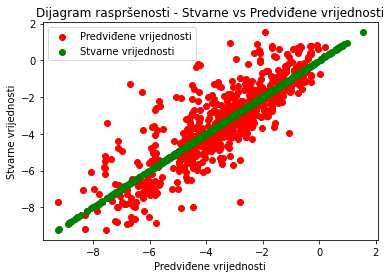

In [84]:
import matplotlib.pyplot as plt

# Predviđanje na testnom skupu
y_pred = model.predict(X_test)

# Plotanje dijagrama raspršenosti
plt.scatter(y_pred, y_test, c='red', label='Predviđene vrijednosti')
plt.scatter(y_test, y_test, c='green', label='Stvarne vrijednosti')
plt.xlabel('Predviđene vrijednosti')
plt.ylabel('Stvarne vrijednosti')
plt.title('Dijagram raspršenosti - Stvarne vs Predviđene vrijednosti')

plt.legend()
plt.show()

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_california_housing
import xgboost as xgb
import multiprocessing

if final_data['Solubility']== final_data:
    print('Parallel Parameter optimization')
    X = final_data.drop('Solubility', axis=1)
    y = final_data['Solubility']
    X, y = fetch_california_housing(return_X_y=True)
    xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count() // 2)
    clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                   'n_estimators': [50, 100, 200]}, verbose=1,
                       n_jobs=2)
    clf.fit(X, y)
    print(clf.best_score_)
    print(clf.best_params_)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().